# Data Preparation and Analysis

In [47]:
import pandas as pd
import numpy as np

In [48]:
data = pd.read_json("data/data.jsonl", lines=True)
data

,question_id,question,human_answer,ai_answer
0,11227809,Why is processing a sorted array faster than p...,You are a victim of branch prediction fail.\n\...,\nThe reason processing a sorted array is fast...
1,927358,How do I undo the most recent local commits in...,"Undo a commit & redo\n$ git commit -m ""Somethi...",\nThe easiest way to undo the most recent loca...
2,2003505,How do I delete a Git branch locally and remot...,Executive Summary\ngit push -d <remote_name> <...,\n1. Delete the local branch:\ngit branch -d <...
3,292357,What is the difference between 'git pull' and ...,"In the simplest terms, git pull does a git fet...",\nGit pull is a combination of git fetch and g...
4,477816,Which JSON content type do I use?\n\nThere are...,For JSON text:\napplication/json\n\n\nThe MIME...,\nThe most widely used and supported JSON cont...
...,...,...,...,...
8808,5878697,How do I remove blank elements from an array?\...,"There are many ways to do this, one is reject\...","\nYes, you can use the Array.filter() method t..."
8809,7054972,Java system properties and environment variabl...,I think the difference between the two boils d...,\nSystem properties (System.getProperties()) a...
8810,7785374,How to prevent column break within an element?...,The correct way to do this is with the break-i...,\nTo prevent the column break within an elemen...
8811,8996852,load and execute order of scripts\n\nThere are...,If you aren't dynamically loading scripts or m...,\n[1]\nThe order of scripts in the <head> tag ...


We immediately see, that ai answers tend to start with newline, so let's strip whitespaces from both answers columns

In [49]:
data.human_answer = data.human_answer.str.strip()
data.ai_answer = data.ai_answer.str.strip()

## Removing duplicates

In [50]:
data.duplicated(subset='question_id').sum()

30

In [51]:
data = data.drop_duplicates(subset=['question_id'], keep='last')

## Length of the answers
Length of human- and ai-produced answers might differ. We don't want to rely on this fact too much

In [52]:
max(data.human_answer.str.len()), max(data.ai_answer.str.len())

(7987, 5045)

Let's limit lengths of the answers to the same max value

In [53]:
data = data[data.human_answer.str.len() <= max(data.ai_answer.str.len())]
data = data.reset_index()
max(data.human_answer.str.len()), max(data.ai_answer.str.len())

(5045, 5045)

Now we need to split the data into two parts, keeping only human answers in one and only ai answers in another. We should take care not to have the same reset_indextwice in the dataset, otherwise we risk overfitting

In [54]:
ai_data = data.iloc[::2] # even rows

ai_data = ai_data.rename(columns={'ai_answer': 'answer'})
ai_data = ai_data.drop('human_answer', axis=1)
ai_data['target'] = 1

human_data = data.iloc[1::2] # odd rows

human_data = human_data.rename(columns={'human_answer': 'answer'})
human_data = human_data.drop('ai_answer', axis=1)
human_data['target'] = 0

Now we merge them back into one labeled dataframe

In [55]:
labeled_data = pd.concat([ai_data, human_data]).sort_index()
labeled_data

,index,question_id,question,answer,target
0,1,927358,How do I undo the most recent local commits in...,The easiest way to undo the most recent local ...,1
1,2,2003505,How do I delete a Git branch locally and remot...,Executive Summary\ngit push -d <remote_name> <...,0
2,3,292357,What is the difference between 'git pull' and ...,Git pull is a combination of git fetch and git...,1
3,4,477816,Which JSON content type do I use?\n\nThere are...,For JSON text:\napplication/json\n\n\nThe MIME...,0
4,5,5767325,How can I remove a specific item from an array...,You can use the Array.prototype.filter() metho...,1
...,...,...,...,...,...
8603,8807,5143769,How do I check if a given Python string is a s...,Try using in like this:\n\n>>> x = 'hello'\n>>...,0
8604,8808,5878697,How do I remove blank elements from an array?\...,"Yes, you can use the Array.filter() method to ...",1
8605,8809,7054972,Java system properties and environment variabl...,I think the difference between the two boils d...,0
8606,8810,7785374,How to prevent column break within an element?...,"To prevent the column break within an element,...",1


Let's double check we don't have question duplicates:

In [56]:
labeled_data.duplicated(subset='question_id').sum()

0

## Tokenizing questions and answers
To handle the text data it's convenient to tokenize it, i.e. split into separate words (tokens). We'll also immediately stem the tokens, so that different forms of the same word become a single token

In [57]:
from nltk.stem import SnowballStemmer

In [58]:
stemmer = SnowballStemmer(language='english')

In [59]:
labeled_data['tokenized_answer'] = labeled_data.answer.apply(lambda x: [stemmer.stem(w) for w in x.split()])
labeled_data['tokenized_question'] = labeled_data.question.apply(lambda x: [stemmer.stem(w) for w in x.split()])
labeled_data[['tokenized_answer', 'tokenized_question']]

,tokenized_answer,tokenized_question
0,"[the, easiest, way, to, undo, the, most, recen...","[how, do, i, undo, the, most, recent, local, c..."
1,"[execut, summari, git, push, -d, <remote_name>...","[how, do, i, delet, a, git, branch, local, and..."
2,"[git, pull, is, a, combin, of, git, fetch, and...","[what, is, the, differ, between, git, pull, an..."
3,"[for, json, text:, application/json, the, mime...","[which, json, content, type, do, i, use?, ther..."
4,"[you, can, use, the, array.prototype.filter(),...","[how, can, i, remov, a, specif, item, from, an..."
...,...,...
8603,"[tri, use, in, like, this:, >>>, x, =, hello, ...","[how, do, i, check, if, a, given, python, stri..."
8604,"[yes,, you, can, use, the, array.filter(), met...","[how, do, i, remov, blank, element, from, an, ..."
8605,"[i, think, the, differ, between, the, two, boi...","[java, system, properti, and, environ, variabl..."
8606,"[to, prevent, the, column, break, within, an, ...","[how, to, prevent, column, break, within, an, ..."


## Feature Engineering
I have several hypotheses about the behaviour of GPT:
1. It tends to repeat parts of the question in its answer
2. Its own vocabulary is smaller and less variate comparing to average human's
3. The size of the answers is less variate than that of humans'

Keeping these in mind I'll create several numerical features and later try to train a regression model on them.

### Helpers

In [60]:
import matplotlib.pyplot as plt

def comparation_hist(column, value_name, bins=30):
    plt.hist(labeled_data[labeled_data.target==0][column], alpha=0.5, label='Human', bins = 30)
    plt.hist(labeled_data[labeled_data.target==1][column], alpha=0.5, label='AI', bins = 30)

    # plt.title('Histograms for col1 and col2')
    plt.xlabel(value_name)
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()

### Feature: Creativity
I'm introducing the term creativity to describe how many original words are used in the answer. Hence the feature:
* `creativity` - number of all unique words in the answer that are not present in the question, divided by the size of the answer

In [61]:
labeled_data['new_words'] = labeled_data.apply(lambda x: set([w for w in x.tokenized_answer if w not in x.tokenized_question]), axis=1)
labeled_data['creativity'] = labeled_data.apply(lambda x: len(x.new_words) / len(x.tokenized_answer) if len(x.tokenized_answer)>0 else 0, axis=1)

In [62]:
labeled_data.creativity.mean()

0.48538911531039786

In [63]:
labeled_data[labeled_data.target==0].creativity.mean(), labeled_data[labeled_data.target==1].creativity.mean()


(0.5413628901931097, 0.429415340427686)

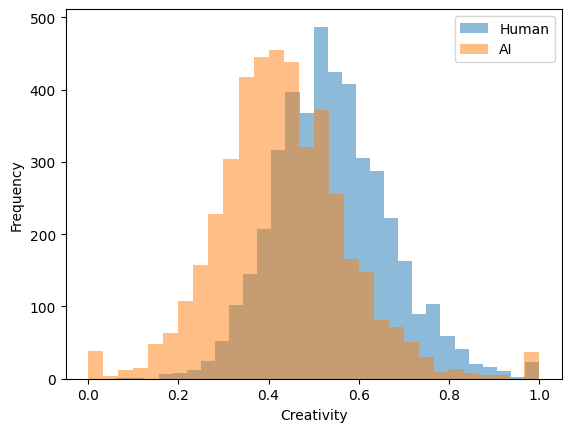

In [64]:
comparation_hist('creativity', 'Creativity')

There is obviously a difference in creativity between humans and AI

### Feature: Vocabulary Size
Assuming that number of unique words may be different in human and AI answers, I'm introducing two more features:
* `n_unique_words` - number of unique words in the answer
* `vocabulary_size` - `unique_words` divided by the size of the tokenized answer

In [65]:
labeled_data['n_unique_words'] = labeled_data.tokenized_answer.apply(lambda x: len(set(x)))
labeled_data['vocabulary_size'] = labeled_data.apply(lambda x: x.n_unique_words / len(x.tokenized_answer) if len(x.tokenized_answer)>0 else 0, axis=1)

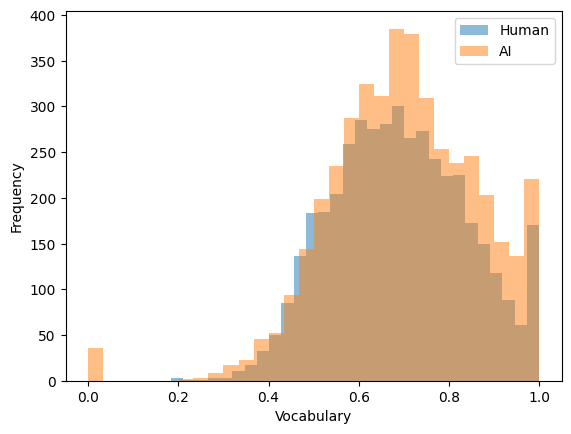

In [66]:
comparation_hist('vocabulary_size', 'Vocabulary')

This metric doesn't seem to be of any value

### Feature: Stealing
Opposite to creativity, stealing shows how many words sequences were stolen from the question and taken into the answer. I'm breaking questions and answers into n-grams (word sequences of length n) and then find the common ngrams. Then I create two features:

* `stealing_strength` - maximum length (number of words) of a stolen ngram
* `stealing_frequency` - total number of stolen ngrams divided by number of unique words

In [67]:
from nltk import everygrams

In [68]:
def find_stolen_ngrams(record):
    ngrams_question = everygrams(record.tokenized_question, min_len=2)
    ngrams_answer = everygrams(record.tokenized_answer, min_len=2)
    ngrams_set = set(ngrams_question).intersection(ngrams_answer)

    for ngram in ngrams_set.copy():
        for i in range(len(ngram)):
            for j in range(i+1, len(ngram)+1):
                if ngram[i:j] in ngrams_set and ngram[i:j] != ngram:
                    ngrams_set.discard(ngram[i:j])

    return ngrams_set

In [69]:
%%time
labeled_data['stolen_ngrams'] = labeled_data.apply(find_stolen_ngrams, axis=1)

CPU times: user 2min 34s, sys: 107 ms, total: 2min 34s
Wall time: 2min 34s


In [70]:
labeled_data['stealing_strength'] = np.log1p(labeled_data.stolen_ngrams.apply(lambda x: max([len(ngram) for ngram in x]) if len(x) > 0 else 0))

In [71]:
labeled_data['stealing_frequency'] = np.log1p(labeled_data.apply(lambda x: len(x.stolen_ngrams) / x.n_unique_words if x.n_unique_words > 0 else 0, axis=1))

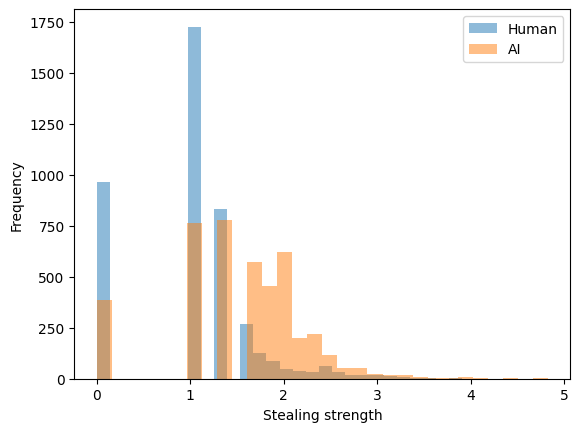

In [72]:
comparation_hist('stealing_strength', 'Stealing strength')

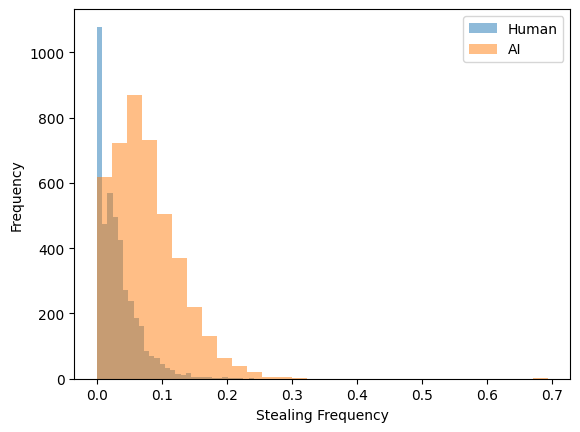

In [73]:
comparation_hist('stealing_frequency', 'Stealing Frequency')

### Feature: Answer Length
Even though I've limited maximum answer length of human- and ai- generated answers, the distribution might still be different. So another feature:
* `answer_length`

In [74]:
labeled_data['answer_length'] = np.log1p(labeled_data.answer.str.len())

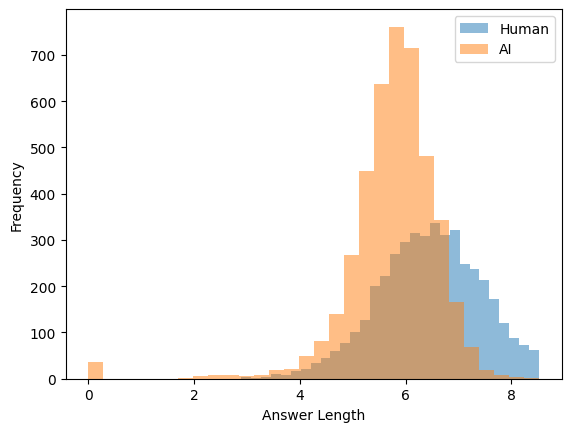

In [75]:
comparation_hist('answer_length', 'Answer Length')

# Training models
I'm going to train several models and compare the results:
1. Logistic regression on the features I've selected
2. Naive Bayes on vectorized answers
3. Combination of the previous two in two-layered pipeline

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from util.train_util import grid_search
from util.plot_util import plot_grid_results

In [77]:
selected_features = ['creativity', 'stealing_strength', 'stealing_frequency', 'answer_length']

## Data split

In [78]:
df_full_train, df_test = train_test_split(labeled_data, test_size=0.2, random_state=30)

## Logistic regression

In [79]:
lr = LogisticRegression()
score = cross_val_score(lr, df_full_train[selected_features], df_full_train.target, scoring='f1').mean()
score

0.7929025030439328

In [80]:
lr_tuning_grid = {
    'C': np.logspace(-3,2,6),
    'solver': ['lbfgs', 'liblinear', 'sag']
}
grid_search_results = grid_search(lr, lr_tuning_grid, df_full_train[selected_features], df_full_train.target)

Tuned Hyperparameters: {'C': 10.0, 'solver': 'lbfgs'}
F1 score : 0.7952249498777714


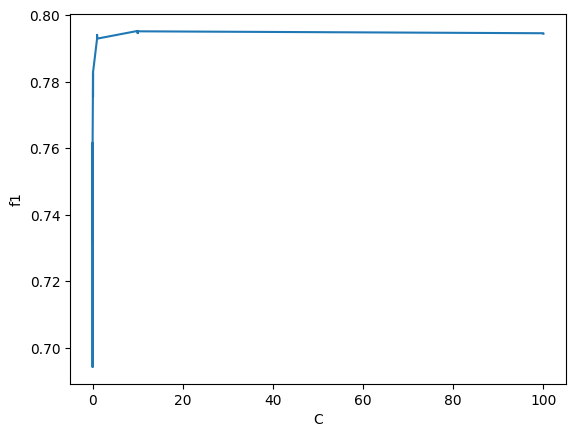

In [81]:
plot_grid_results(grid_search_results, x_var='C')

## Naive Bayes

In [82]:
count_vectorizer = CountVectorizer(min_df=10, analyzer=lambda x: x)
vectors = count_vectorizer.fit_transform(df_full_train.tokenized_answer)
vectors.shape

(6886, 3487)

In [83]:
nb = ComplementNB()
score = cross_val_score(nb, vectors, df_full_train.target, scoring='f1').mean()
score

0.8582001705391262

In [84]:
nb_tuning_grid = {
    'alpha': np.logspace(-3,2,6)
}

grid_search_results = grid_search(nb, nb_tuning_grid, vectors, df_full_train.target)

Tuned Hyperparameters: {'alpha': 1.0}
F1 score : 0.8582001705391262


## 2-Layered Pipeline
 Both Naive Bayes and Logistic Regression show good results. At the same time they use different aspects of data, so maybe it's possible to make them enhance each other.
So I plan to do the following:
1. Vectorize the `answer` column and train Naive Bayes on it
2. Apply Naive Bayes to the rows to predict probability `predict_proba()`.
3. Add this probability as another numerical feature to the data_frame
4. Combine this probability with `selected_features` and train Logistic Regression on the new set of numerical features

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import ComplementNB
from sklearn.compose import ColumnTransformer

In [86]:
X_train = df_full_train[['tokenized_answer'] + selected_features]
y_train = df_full_train.target
X_test = df_test[['tokenized_answer'] + selected_features]
y_test = df_test.target

In order to do this trick, I need a custom transformer that wraps the Naive Bayes classifier and uses `predict_proba` in the `transform` method

In [87]:
class ComplementNBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.clf = ComplementNB()

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self

    def transform(self, X):
        probas = self.clf.predict_proba(X)
        return pd.DataFrame(np.array([x[1] for x in probas]), columns=['nb_probability'])

Now I'm creating the pipeline that implements the plan:

In [88]:
nb_pipe = Pipeline([('c_vect', CountVectorizer(min_df=10, analyzer=lambda x: x)),
                     ('nb_proba', ComplementNBTransformer())])

columns = [('nb_pipe', nb_pipe, 'tokenized_answer')]

col_trans = ColumnTransformer(columns, remainder = 'passthrough') # the `remainder` part ensures that `selected_features` are passed down the pipeline and later combined with the outpuc of nb_pipe

full_pipe = Pipeline([('proba', col_trans),
                     ('lr', LogisticRegression(C=10.0, solver='lbfgs'))])

cross_val_score(full_pipe, X_train, y_train, scoring='f1').mean()

0.8949596334355041

### Fine tuning the pipeline
Parameters of Naive Bayes and Logistic Regression have already been tuned, so here I'm only tuning the `min_df` parameter of CountVectorizer:

In [89]:
pipe_tuning_grid = {
    'proba__nb_pipe__c_vect__min_df': range(5, 16)
}
grid_search_results = grid_search(full_pipe, pipe_tuning_grid, X_train, y_train)

Tuned Hyperparameters: {'proba__nb_pipe__c_vect__min_df': 7}
F1 score : 0.8983049062857453


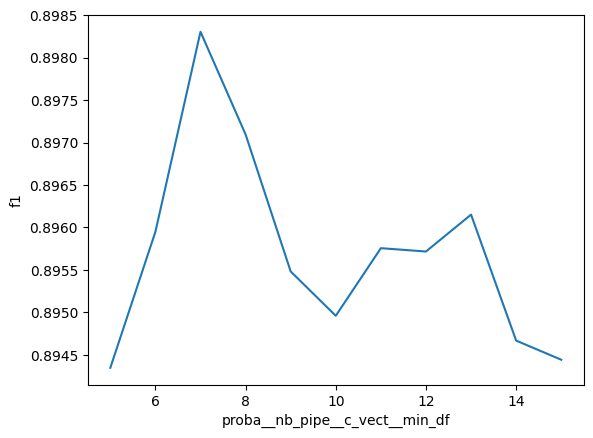

In [90]:
plot_grid_results(grid_search_results, x_var='proba__nb_pipe__c_vect__min_df')

In [91]:
full_pipe.set_params(**{'proba__nb_pipe__c_vect__min_df': 7})
full_pipe.fit(X_train, y_train)

Pipeline(steps=[('proba',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nb_pipe',
                                                  Pipeline(steps=[('c_vect',
                                                                   CountVectorizer(analyzer=<function <lambda> at 0x7fa5df9737f0>,
                                                                                   min_df=7)),
                                                                  ('nb_proba',
                                                                   ComplementNBTransformer())]),
                                                  'tokenized_answer')])),
                ('lr', LogisticRegression(C=10.0))])

In [92]:
f1_score(full_pipe.predict(X_test), y_test)

0.8997668997668996